## Capstone Project - LV - The Battle of Neighborhoods (Week 2)


### Making an App or Website to choose a city and associated with Foursquare data to make a choice to find the best location from a date and a budget.

In [1]:
# Libraries
!pip install geopy
!conda install -c conda-forge folium=0.5.0 --yes 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Requirement not upgraded as not directly required: geopy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py_0 conda-forge
    blas:    1.0-mkl               
    branca:  0.3.0-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge

blas-1.0-mkl.t 100% |################################| Time: 0:00:00   7.30 MB/s
branca-0.3.0-p 100% |################################| Time: 0:00:00 328.16 kB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00 378.73 kB/s
altair-2.2.2-p 100% |################################| Time: 0:00:00 474.84 kB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  38.00 MB/s
Matplotlib version:  2.1.0
Libraries imported.


In [2]:
## download data
paris_data = pd.read_csv("https://lvdesign.com.fr/coursera_data/paris.csv")
paris_data 

,Lieux,Latitude,Longitude
0,Musée du Louvre,48.860611,2.335450
1,Notre Dame de Paris,48.852968,2.347708
2,Arc de Triomphe,48.873792,2.295028
3,Tour Eiffel,48.858370,2.294481


In [3]:
# Localise Lieux on the map Paris
address = 'Paris, FR'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566101, 2.3514992.


In [4]:
# create map of Paris using latitude and longitude values
map_Paris = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(paris_data['Latitude'], paris_data['Longitude'], paris_data['Lieux']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Paris)  
    
map_Paris

In [5]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'XDP05EROIGY2VHJ3RZNRVGCEECJKCBAV0L4JMC4F4SCL0NAF' # your Foursquare ID
CLIENT_SECRET = 'XHKK22SSQYX0REMVWFGNG3GTY5I2HGPPOUERFOEFPIR0YPNO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XDP05EROIGY2VHJ3RZNRVGCEECJKCBAV0L4JMC4F4SCL0NAF
CLIENT_SECRET:XHKK22SSQYX0REMVWFGNG3GTY5I2HGPPOUERFOEFPIR0YPNO


## Explore the city

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,            
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Lieux', 
                  'Lieux Latitude', 
                  'Lieux Longitude', 
                  'Venue',
                  'Venue id',                
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'
                             
                   ]
    
    return(nearby_venues)

## Rating of Venue

In [7]:
# test rating
# Musée du Louvre 4adcda10f964a520af3521e3
# Cathédrale Notre-Dame de Paris 4adcda09f964a520e83321e3
# Tour Eiffel 51a2445e5019c80b56934c75
# Arc de Triomphe 4adcda09f964a520de3321e3

venue_id ={
    'Musée du Louvre': '4adcda10f964a520af3521e3',
    'Cathédrale Notre-Dame de Paris': '4adcda09f964a520e83321e3',
    'Tour Eiffel': '51a2445e5019c80b56934c75',
    'Arc de Triomphe': '4adcda09f964a520de3321e3'
}

for key,value in venue_id.items():
    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(value, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        print('Venue :', key)
        print('Rating : ', result['response']['venue']['rating'])
        print('Total Tips : ', result['response']['venue']['tips']['count'])
        print('Nb Likes : ', result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])
        print('Nb Likes / Total Tips', (result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])/ (result['response']['venue']['tips']['count']) *100 )
        
        print()

    except:
        print('This venue has not been rated yet.')



Venue : Cathédrale Notre-Dame de Paris
Rating :  9.6
Total Tips :  945
Nb Likes :  57
Nb Likes / Total Tips 6.031746031746032

Venue : Musée du Louvre
Rating :  9.5
Total Tips :  2134
Nb Likes :  167
Nb Likes / Total Tips 7.825679475164011

Venue : Tour Eiffel
Rating :  9.5
Total Tips :  2446
Nb Likes :  937
Nb Likes / Total Tips 38.30744071954211

Venue : Arc de Triomphe
Rating :  9.6
Total Tips :  687
Nb Likes :  103
Nb Likes / Total Tips 14.992721979621543



## Category of Venue

In [8]:
paris_data_venues = getNearbyVenues(names=paris_data['Lieux'],
                                   latitudes=paris_data['Latitude'],
                                   longitudes=paris_data['Longitude']
                                  )
#print(paris_data_venues.shape)
paris_data_venues

Musée du Louvre
Notre Dame de Paris
Arc de Triomphe
Tour Eiffel


,Lieux,Lieux Latitude,Lieux Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,Musée du Louvre,48.860611,2.335450,Musée du Louvre,4adcda10f964a520af3521e3,48.860847,2.336440,Art Museum
1,Musée du Louvre,48.860611,2.335450,La Vénus de Milo (Vénus de Milo),5864efb745c3ed1e7d88e96d,48.861100,2.335863,Exhibit
2,Musée du Louvre,48.860611,2.335450,Cour Carrée du Louvre,4c079d740ed3c928b6be797d,48.860360,2.338543,Plaza
3,Musée du Louvre,48.860611,2.335450,Mona Lisa | La Joconde,56f279c4cd10850a585f5e31,48.860139,2.335337,Exhibit
4,Musée du Louvre,48.860611,2.335450,Carrousel du Louvre,4adcda1df964a5202e3921e3,48.861764,2.334344,Shopping Mall
5,Musée du Louvre,48.860611,2.335450,Cour Napoléon,5072efe7e4b0c34b5146e7fd,48.861172,2.335088,Plaza
6,Musée du Louvre,48.860611,2.335450,Place du Palais Royal,4b071505f964a520dcf622e3,48.862523,2.336688,Plaza
7,Musée du Louvre,48.860611,2.335450,Café Marly,4adcda04f964a520503221e3,48.861596,2.335676,Café
8,Musée du Louvre,48.860611,2.335450,La Maison du Chocolat,4c21f8fd13c00f4729ab86de,48.861417,2.334132,Chocolate Shop
9,Musée du Louvre,48.860611,2.335450,Vestige de la forteresse du Louvre et salle Sa...,4f6dabf5003944083fe0002e,48.861577,2.333508,Historic Site


## Count 

In [9]:
# More intersting
#Let's check how many venues were returned for each lieux
paris_data_venues.groupby('Lieux').count()

,Lieux Latitude,Lieux Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
Lieux,,,,,,,
Arc de Triomphe,100,100,100,100,100,100,100
Musée du Louvre,96,96,96,96,96,96,96
Notre Dame de Paris,100,100,100,100,100,100,100
Tour Eiffel,50,50,50,50,50,50,50


## Histogramme

In [10]:
df_view_new = paris_data_venues.groupby('Lieux').count()
df_paris_histo = df_view_new['Venue Category']
df_paris_histo

Lieux
Arc de Triomphe        100
Musée du Louvre         96
Notre Dame de Paris    100
Tour Eiffel             50
Name: Venue Category, dtype: int64

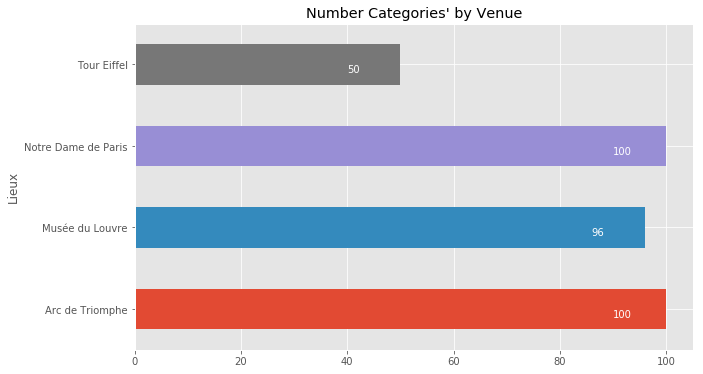

In [11]:
df_paris_histo.plot(kind='barh', figsize=(10,6))

#plt.xlabel('name') # add to x-label to the plot
#plt.ylabel('Number de categories') # add y-label to the plot
plt.title('Number Categories\' by Venue') # add title to the plot

for index, value in enumerate(df_paris_histo): 
    label = format(int(value), ',') 
    plt.annotate(label, xy=(value - 10, index - 0.10), color='white')
    
plt.show()

## Analyse for each Categories

In [13]:
#Analyze Each Lieux
# one hot encoding
paris_onehot = pd.get_dummies(paris_data_venues[['Venue Category']], prefix="", prefix_sep="")

# add Lieux column back to dataframe
paris_onehot['Lieux'] = paris_data_venues['Lieux'] 

# move lieux column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot

,Lieux,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,Auvergne Restaurant,Bagel Shop,Bakery,Bar,Bistro,Bookstore,Brasserie,Breakfast Spot,Breton Restaurant,Bridge,Burger Joint,Bus Stop,Café,Candy Store,Cantonese Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Exhibit,Falafel Restaurant,Fast Food Restaurant,Flower Shop,Fountain,French Restaurant,Furniture / Home Store,Garden,Gift Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lebanese Restaurant,Library,Men's Store,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Nightclub,Park,Pastry Shop,Pedestrian Plaza,Pizza Place,Plaza,Pub,Ramen Restaurant,Restaurant,Romanian Restaurant,Roof Deck,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,South American Restaurant,Spa,Sports Bar,Steakhouse,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,Yoga Studio
0,Musée du Louvre,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Musée du Louvre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [14]:
# Next, 
# let's group rows by Lieux
# and by taking the mean of the frequency of occurrence of each category
paris_grouped = paris_onehot.groupby('Lieux').mean().reset_index()
paris_grouped

,Lieux,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,Auvergne Restaurant,Bagel Shop,Bakery,Bar,Bistro,Bookstore,Brasserie,Breakfast Spot,Breton Restaurant,Bridge,Burger Joint,Bus Stop,Café,Candy Store,Cantonese Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Exhibit,Falafel Restaurant,Fast Food Restaurant,Flower Shop,Fountain,French Restaurant,Furniture / Home Store,Garden,Gift Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lebanese Restaurant,Library,Men's Store,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Nightclub,Park,Pastry Shop,Pedestrian Plaza,Pizza Place,Plaza,Pub,Ramen Restaurant,Restaurant,Romanian Restaurant,Roof Deck,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,South American Restaurant,Spa,Sports Bar,Steakhouse,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,Yoga Studio
0,Arc de Triomphe,0.000000,0.01,0.000000,0.000000,0.01,0.000000,0.00,0.01,0.030000,0.010000,0.010000,0.000000,0.00,0.000000,0.01,0.000000,0.00,0.00,0.0000,0.000000,0.00,0.00,0.00,0.01,0.000000,0.000000,0.010000,0.010000,0.020000,0.01,0.00,0.00,0.00000,0.00,0.00,0.000000,0.00,0.01,0.000000,0.00,0.010000,0.000000,0.00,0.01,0.00,0.00,0.140,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.300000,0.01,0.000000,0.01,0.00,0.060000,0.01000,0.00,0.03,0.00,0.01,0.000000,0.00,0.00,0.02,0.00,0.00,0.01,0.01,0.01,0.02,0.000000,0.030000,0.000000,0.00,0.00,0.000000,0.010000,0.01,0.000000,0.01,0.00,0.01,0.020000,0.01,0.00,0.000000,0.01,0.000000,0.000000,0.000000,0.00,0.01,0.00,0.01,0.000000,0.01,0.000000,0.02,0.000000,0.00,0.01,0.00,0.00,0.00,0.000000,0.01,0.00,0.00
1,Musée du Louvre,0.010417,0.00,0.020833,0.010417,0.00,0.010417,0.00,0.00,0.010417,0.020833,0.020833,0.010417,0.00,0.010417,0.00,0.010417,0.00,0.00,0.0625,0.010417,0.00,0.00,0.00,0.00,0.010417,0.010417,0.010417,0.020833,0.041667,0.00,0.00,0.00,0.03125,0.00,0.00,0.010417,0.00,0.00,0.010417,0.00,0.010417,0.041667,0.00,0.00,0.00,0.00,0.125,0.010417,0.010417,0.00,0.010417,0.00,0.00,0.010417,0.041667,0.00,0.00,0.083333,0.00,0.010417,0.00,0.00,0.010417,0.03125,0.00,0.00,0.00,0.00,0.010417,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.010417,0.010417,0.010417,0.00,0.00,0.020833,0.072917,0.00,0.010417,0.00,0.00,0.00,0.010417,0.00,0.00,0.010417,0.00,0.010417,0.010417,0.010417,0.00,0.00,0.00,0.00,0.010417,0.00,0.020833,0.00,0.010417,0.00,0.00,0.00,0.00,0.00,0.010417,0.00,0.00,0.00
2,Notre Dame de Paris,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.01,0.00,0.020000,0.040000,0.010000,0.060000,0.00,0.000000,0.00,0.000000,0.03,0.00,0.0200,0.010000,0.01,0.00,0.01,0.00,0.010000,0.010000,0.000000,0.010000,0.010000,0.00,0.02,0.00,0.00000,0.01,0.01,0.000000,0.00,0.00,0.010000,0.01,0.000000,0.000000,0.01,0.00,0.01,0.01,0.150,0.000000,0.020000,0.00,0.000000,0.00,0.01,0.000000,0.030000,0.01,0.01,0.050000,0.00,0.020000,0.01,0.01,0.000000,0.03000,0.01,0.00,0.01,0.00,0.000000,0.02,0.00,0.00,0.03,0.01,0.00,0.00,0.01,0.00,0.000000,0.000000,0.020000,0.02,0.01,0.010000,0.040000,0.01,0.000000,0.00,0.00,0.00,0.000000,0.00,0.01,0.000000,0.01,0.000000,0.000000,0.000000,0.01,0.00,0.01,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.02,0.00,0.00,0.000000,0.01,0.01,0.01
3,Tour Eiffel,0.000000,0.00,0.020

### the top 10 most common venues

In [15]:
#
#Let's print each Lieux along with the top 10 most common venues¶
num_top_venues = 10

for hood in paris_grouped['Lieux']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Lieux'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arc de Triomphe----
                venue  freq
0               Hotel  0.30
1   French Restaurant  0.14
2  Italian Restaurant  0.06
3       Jewelry Store  0.03
4              Bakery  0.03
5           Nightclub  0.03
6     Thai Restaurant  0.02
7         Coffee Shop  0.02
8         Men's Store  0.02
9      Sandwich Place  0.02


----Musée du Louvre----
                 venue  freq
0    French Restaurant  0.12
1                Hotel  0.08
2                Plaza  0.07
3                 Café  0.06
4          Coffee Shop  0.04
5        Historic Site  0.04
6              Exhibit  0.04
7       Cosmetics Shop  0.03
8  Japanese Restaurant  0.03
9               Bistro  0.02


----Notre Dame de Paris----
                 venue  freq
0    French Restaurant  0.15
1            Bookstore  0.06
2                Hotel  0.05
3                  Bar  0.04
4                Plaza  0.04
5        Historic Site  0.03
6  Japanese Restaurant  0.03
7   Mexican Restaurant  0.03
8         Burger Joint  0.03
9  

In [16]:
#Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
#Now let's create the new dataframe 
#and display the top 10 venues for each Lieux.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Lieux']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
lieux_venues_sorted = pd.DataFrame(columns=columns)
lieux_venues_sorted['Lieux'] = paris_grouped['Lieux']

for ind in np.arange(paris_grouped.shape[0]):
    lieux_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

lieux_venues_sorted

,Lieux,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arc de Triomphe,Hotel,French Restaurant,Italian Restaurant,Nightclub,Jewelry Store,Bakery,Sandwich Place,Thai Restaurant,Coffee Shop,Movie Theater
1,Musée du Louvre,French Restaurant,Hotel,Plaza,Café,Historic Site,Exhibit,Coffee Shop,Japanese Restaurant,Cosmetics Shop,Bistro
2,Notre Dame de Paris,French Restaurant,Bookstore,Hotel,Bar,Plaza,Japanese Restaurant,Burger Joint,Historic Site,Mexican Restaurant,Comic Shop
3,Tour Eiffel,French Restaurant,Italian Restaurant,Hotel,Café,Bakery,Garden,Bistro,Plaza,Theme Park Ride / Attraction,Bus Stop


## Search by Interest's Venues with Clusters method

In [18]:
# set number of clusters
kclusters = 4

paris_grouped_clustering = paris_grouped.drop('Lieux', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 1, 2], dtype=int32)

In [19]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each Lieux.

paris_merged = paris_data

# add clustering labels
paris_merged['Cluster Labels'] = kmeans.labels_

paris_merged = paris_merged.join(lieux_venues_sorted.set_index('Lieux'), on='Lieux')
paris_merged 
# check the last columns!

,Lieux,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Musée du Louvre,48.860611,2.335450,0,French Restaurant,Hotel,Plaza,Café,Historic Site,Exhibit,Coffee Shop,Japanese Restaurant,Cosmetics Shop,Bistro
1,Notre Dame de Paris,48.852968,2.347708,3,French Restaurant,Bookstore,Hotel,Bar,Plaza,Japanese Restaurant,Burger Joint,Historic Site,Mexican Restaurant,Comic Shop
2,Arc de Triomphe,48.873792,2.295028,1,Hotel,French Restaurant,Italian Restaurant,Nightclub,Jewelry Store,Bakery,Sandwich Place,Thai Restaurant,Coffee Shop,Movie Theater
3,Tour Eiffel,48.858370,2.294481,2,French Restaurant,Italian Restaurant,Hotel,Café,Bakery,Garden,Bistro,Plaza,Theme Park Ride / Attraction,Bus Stop


### Visualisation

In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Lieux'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0 :  Musée du louvre


In [21]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,48.860611,Hotel,Plaza,Café,Historic Site,Exhibit,Coffee Shop,Japanese Restaurant,Cosmetics Shop,Bistro


### Cluster 1 : Arc de Triomphe

In [130]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,48.873792,French Restaurant,Italian Restaurant,Nightclub,Jewelry Store,Bakery,Sandwich Place,Thai Restaurant,Coffee Shop,Movie Theater


### Cluster 2 : Tour Eiffel


In [131]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,48.85837,Italian Restaurant,Hotel,Café,Bakery,Garden,Bistro,Plaza,Theme Park Ride / Attraction,Bus Stop


### Cluster 3 : Notre Dame de Paris

In [132]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]


,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,48.852968,Bookstore,Hotel,Bar,Plaza,Japanese Restaurant,Burger Joint,Historic Site,Mexican Restaurant,Comic Shop


## View on particular Venue : Tour Eiffel

In [24]:
#Get the Lieux latitude and longitude values.
lieux_latitude = paris_data.loc[3, 'Latitude'] # lieux latitude value
lieux_longitude = paris_data.loc[3, 'Longitude'] # Lieux  longitude value

lieux_name = paris_data.loc[3, 'Lieux'] # Lieux name

print('Latitude and longitude values of {} are {}, {}.'.format(lieux_name, 
                                                               lieux_latitude, 
                                                               lieux_longitude))

Latitude and longitude values of Tour Eiffel are 48.8583701, 2.2944812999999997.


In [25]:
#First, let's create the GET request URL. Name your URL url.
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# type your answer here
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lieux_latitude,lieux_longitude,radius,LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=XDP05EROIGY2VHJ3RZNRVGCEECJKCBAV0L4JMC4F4SCL0NAF&client_secret=XHKK22SSQYX0REMVWFGNG3GTY5I2HGPPOUERFOEFPIR0YPNO&v=20180605&ll=48.8583701,2.2944812999999997&radius=500&limit=100'

In [26]:
#Send the GET request and examine the resutls
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5b8567174434b92ab4057f68'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-51a2445e5019c80b56934c75-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/government_monument_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d12d941735',
         'name': 'Monument / Landmark',
         'pluralName': 'Monuments / Landmarks',
         'primary': True,
         'shortName': 'Landmark'}],
       'id': '51a2445e5019c80b56934c75',
       'location': {'address': '5 avenue Anatole France',
        'cc': 'FR',
        'city': 'Paris',
        'country': 'France',
        'crossStreet': 'Parc du Champ-de-Mars',
        'distance': 14,
        'formattedAddress': ['5 avenue Anatole France (Parc du Champ-de-Mars)',
         '75007 

In [28]:
# def Categories with Foursquare Type
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
# determine Venues 
# Now we are ready to clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng,id
0,Tour Eiffel,Monument / Landmark,48.858249,2.294426,51a2445e5019c80b56934c75
1,Le Jules Verne,French Restaurant,48.858245,2.294530,4b5972b9f964a5208b8828e3
2,Restaurant 58 Tour Eiffel,French Restaurant,48.858387,2.294067,4e078807e4cdefcff6dce4f6
3,Bar à Champagne de la Tour Eiffel,Champagne Bar,48.858313,2.294411,4d55537db4deb1f71d41037a
4,Carrousel de la Tour Eiffel,Theme Park Ride / Attraction,48.858972,2.292631,4dab1ab0fa8cc76497446a89
5,Residence Charles Floquet,Hotel,48.856306,2.294318,54c57345498e47f3d60203c7
6,Musée du Quai Branly – Jacques Chirac,Art Museum,48.860849,2.297423,4adcda10f964a520ae3521e3
7,Hôtel Pullman Paris Tour Eiffel,Hotel,48.855791,2.292605,4c0f74e2d64c0f479fbc295d
8,Capriccio Sorrentino,Italian Restaurant,48.859208,2.297896,50b60a4ee4b0c55f394cee7a
9,Bistrot de la Tour Eiffel,Bistro,48.859305,2.297612,4ccd950e2dc437041830cf08


### Count number of Rating, Tips and Likes for this Venue : Tour Eiffel

In [101]:
# Comptabiliser le nombre de rating selon le lieux

venue_id = '51a2445e5019c80b56934c75' # Tour Eiffel 51a2445e5019c80b56934c75
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print('Rating : ', result['response']['venue']['rating'])
    print('Total Tips : ', result['response']['venue']['tips']['count'])
    print('Nb Likes : ', result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])
    print('Nb Likes / Total Tips', (result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])/ (result['response']['venue']['tips']['count']) *100 )
except:
    print('This venue has not been rated yet.')

Rating :  9.5
Total Tips :  2446
Nb Likes :  937
Nb Likes / Total Tips 38.30744071954211


### Look at Tips and text

In [104]:
## Ecco Tips
venue_id = '51a2445e5019c80b56934c75'
limit = 200 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5b8572694c1f670ec54c23a8'},
 'response': {'tips': {'count': 2446,
   'items': [{'agreeCount': 23,
     'authorInteractionType': 'liked',
     'canonicalUrl': 'https://foursquare.com/item/583cb3b95da8f465d21b9c0b',
     'createdAt': 1480373177,
     'disagreeCount': 0,
     'id': '583cb3b95da8f465d21b9c0b',
     'lang': 'en',
     'lastUpvoteTimestamp': 1535401825,
     'lastVoteText': 'Upvoted 19 hours ago',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'photo': {'createdAt': 1480373233,
      'height': 1920,
      'id': '583cb3f1266c1177e729d1c3',
      'prefix': 'https://igx.4sqi.net/img/general/',
      'source': {'name': 'Foursquare for iOS',
       'url': 'https://foursquare.com/download/#/iphone'},
      'suffix': '/11728894_nh993kr9cn6RWHYFoV64rwVLUuz87TppYdOxe67naos.jpg',
      'visibility': 'public',
      'width': 1440},
     'photourl': 'https://igx.4sqi.net/img/general/original/11728894_nh993kr9cn6RWHYFoV64rwVLUuz8

In [105]:
# test avis sur Lieux
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'lastVoteText', 'photo', 'lastUpvoteTimestamp', 'type', 'lang', 'agreeCount', 'canonicalUrl', 'logView', 'authorInteractionType', 'createdAt', 'user', 'photourl', 'disagreeCount', 'todo', 'likes', 'text'])

In [106]:
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips) # json normalize tips

# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered

,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.gender,user.id
0,The views at night was the best. You can either catch a lift to the top or brave taking the stairs. Dining at one of the two on-site restaurants is a must do and made it a trip to remember.,23,0,583cb3b95da8f465d21b9c0b,Lina,Bell,female,11728894


## Research of Spots to this venue : Notre Dame de Paris

In [109]:
#First, let's create the GET request URL. Name your URL url.
LIMIT = 150 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=XDP05EROIGY2VHJ3RZNRVGCEECJKCBAV0L4JMC4F4SCL0NAF&client_secret=XHKK22SSQYX0REMVWFGNG3GTY5I2HGPPOUERFOEFPIR0YPNO&ll=48.8566101,2.3514992&v=20180605&radius=500&limit=150'

In [110]:
results = requests.get(url).json()
'There are {} popular spots around.'.format(len(results['response']['groups'][0]['items']))

'There are 100 popular spots around.'

In [111]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'reasonName': 'globalInteractionReason',
    'summary': 'This spot is popular',
    'type': 'general'}]},
 'referralId': 'e-0-4bf41231e5eba59334341f90-0',
 'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/plaza_',
     'suffix': '.png'},
    'id': '4bf58dd8d48988d164941735',
    'name': 'Plaza',
    'pluralName': 'Plazas',
    'primary': True,
    'shortName': 'Plaza'}],
  'id': '4bf41231e5eba59334341f90',
  'location': {'address': "Place de l'Hôtel de Ville",
   'cc': 'FR',
   'city': 'Paris',
   'country': 'France',
   'distance': 35,
   'formattedAddress': ["Place de l'Hôtel de Ville", '75004 Paris', 'France'],
   'lat': 48.85692655101013,
   'lng': 2.3515443262343716,
   'postalCode': '75004',
   'state': 'Île-de-France'},
  'name': "Place de l'Hôtel de Ville – Esplanade de la Libération",
  'photos': {'count': 0, 'groups': []}}}

In [112]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [114]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Place de l'Hôtel de Ville – Esplanade de la Libération,Plaza,Place de l'Hôtel de Ville,FR,Paris,France,NaN,35,"[Place de l'Hôtel de Ville, 75004 Paris, France]",NaN,48.856927,2.351544,NaN,75004,Île-de-France,4bf41231e5eba59334341f90
1,BHV Marais,Department Store,14 rue du Temple,FR,Paris,France,Rue de Rivoli,147,"[14 rue du Temple (Rue de Rivoli), 75004 Paris, France]","[{'lng': 2.3531556129455566, 'label': 'display', 'lat': 48.85735641341348}]",48.857356,2.353156,NaN,75004,Île-de-France,4b4b6a3df964a520b89a26e3
2,L'Alsacien,Alsatian Restaurant,6 rue Saint-Bon,FR,Paris,France,NaN,202,"[6 rue Saint-Bon, 75004 Paris, France]","[{'lng': 2.3503806119494897, 'label': 'display', 'lat': 48.85827502747949}]",48.858275,2.350381,NaN,75004,Île-de-France,54351b59498e123ee4afc7ff
3,LUSH,Cosmetics Shop,3 rue du Renard,FR,Paris,France,NaN,131,"[3 rue du Renard, 75004 Paris, France]","[{'lng': 2.3516219632738213, 'label': 'display', 'lat': 48.85779127633849}]",48.857791,2.351622,NaN,75004,Île-de-France,4d628e33e4fe548152b8979e
4,Häagen-Dazs,Ice Cream Shop,1 rue d'Arcole,FR,Paris,France,NaN,218,"[1 rue d'Arcole, 75004 Paris, France]","[{'lng': 2.3501247789041226, 'label': 'display', 'lat': 48.85487262126511}]",48.854873,2.350125,NaN,75004,Île-de-France,4cb2fc20db32f04d6da9d34d
5,Paris Rendez-Vous,Souvenir Shop,29 rue de Rivoli,FR,Paris,France,Rue Lobau,115,"[29 rue de Rivoli (Rue Lobau), 75004 Paris, France]","[{'lng': 2.352841377331694, 'label': 'display', 'lat': 48.857149856247275}]",48.857150,2.352841,NaN,75004,Île-de-France,5361075a498ea34171cb06ca
6,Tour Saint-Jacques,Historic Site,88 rue de Rivoli,FR,Paris,France,NaN,248,"[88 rue de Rivoli, 75004 Paris, France]","[{'lng': 2.348874807357788, 'label': 'display', 'lat': 48.858030532545826}]",48.858031,2.348875,NaN,75004,Île-de-France,4b5c7d1ff964a5205f3229e3
7,Square de la Tour Saint-Jacques,Park,88 rue de Rivoli,FR,Paris,France,NaN,245,"[88 rue de Rivoli, 75001 Paris, France]","[{'lng': 2.348756790161133, 'label': 'display', 'lat': 48.857882297703746}]",48.857882,2.348757,NaN,75001,Île-de-France,4dbd336b6a23e294ba405cfa
8,Berges de Seine – Rive droite,Pedestrian Plaza,De la passerelle Léopold-Sédar-Senghor au port de l'Arsenal,FR,Paris,France,NaN,174,"[De la passerelle Léopold-Sédar-Senghor au port de l'Arsenal, Paris, France]","[{'lng': 2.352289446225441, 'label': 'display', 'lat': 48.855130568830376}]",48.855131,2.352289,NaN,NaN,Île-de-France,58d800df9435a979b8a645fa
9,Galerie Azzedine Alaïa,Art Gallery,18 rue de la Verrerie,FR,Paris,France,NaN,291,"[18 rue de la Verrerie, 75003 Paris, France]","[{'lng': 2.3552169725375203, 'label': 'display', 'lat': 48.857544773243966}]",48.857545,2.355217,NaN,75003,Île-de-France,4c0bc2fdbbc676b018f64bd5


In [115]:
newTest = dataframe_filtered[['name', 'categories']]
newTest

,name,categories
0,Place de l'Hôtel de Ville – Esplanade de la Libération,Plaza
1,BHV Marais,Department Store
2,L'Alsacien,Alsatian Restaurant
3,LUSH,Cosmetics Shop
4,Häagen-Dazs,Ice Cream Shop
5,Paris Rendez-Vous,Souvenir Shop
6,Tour Saint-Jacques,Historic Site
7,Square de la Tour Saint-Jacques,Park
8,Berges de Seine – Rive droite,Pedestrian Plaza
9,Galerie Azzedine Alaïa,Art Gallery


In [116]:
# Some activities
print(dataframe_filtered.categories.unique())

['Plaza' 'Department Store' 'Alsatian Restaurant' 'Cosmetics Shop'
 'Ice Cream Shop' 'Souvenir Shop' 'Historic Site' 'Park' 'Pedestrian Plaza'
 'Art Gallery' 'Pastry Shop' 'Cocktail Bar' "Men's Store"
 'Furniture / Home Store' 'Clothing Store' 'French Restaurant' 'Gay Bar'
 'Lyonese Bouchon' 'Hot Dog Joint' 'Frozen Yogurt Shop' 'Gastropub'
 'Auvergne Restaurant' 'Record Shop' 'Café' 'Flower Shop' 'Fountain'
 'Chinese Restaurant' 'Coffee Shop' 'Bagel Shop' 'Dessert Shop'
 "Women's Store" 'Tapas Restaurant' 'Gluten-free Restaurant' 'Theater'
 'Hobby Shop' 'Seafood Restaurant' 'Pet Store' 'Tea Room' 'Church'
 'Portuguese Restaurant' 'Restaurant' 'Scenic Lookout' 'Art Museum'
 'Jazz Club' 'Pub' 'Lingerie Store' 'Bookstore' 'Hotel' 'Bakery'
 'Arts & Crafts Store' 'Sushi Restaurant' 'Bistro' 'Memorial Site' 'Lounge'
 'Bar' 'Breakfast Spot' 'Burger Joint']


## Visualisation with Word Cloud

In [117]:
## word clouds sur les tendances de ce lieux
!conda install -c conda-forge wordcloud==1.4.1 --yes


# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
wordcloud                 1.4.1                    py35_0    conda-forge
Wordcloud is installed and imported!


In [118]:
newTest_words = dataframe_filtered[['categories']]
newTest_words.head()

,categories
0,Plaza
1,Department Store
2,Alsatian Restaurant
3,Cosmetics Shop
4,Ice Cream Shop


In [119]:
newTest_words.to_csv('myTexteTourEiffel.txt', sep=',', index=False)

In [120]:
myTest = open('myTexteTourEiffel.txt', 'r').read()

In [121]:
stopwords = set(STOPWORDS)

In [122]:
tour_eiffel_wc = WordCloud(
background_color='white',
    max_words=2000,
    stopwords=stopwords
)

tour_eiffel_wc.generate(myTest)

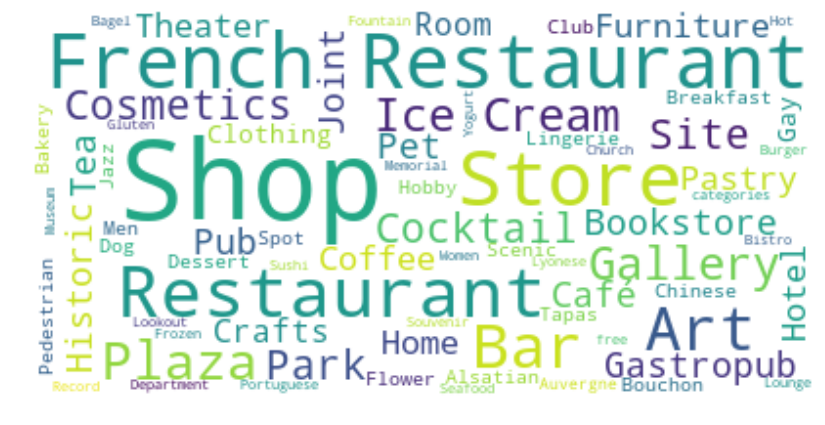

In [123]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(tour_eiffel_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


## Map Visualisation

In [124]:
#Let's visualize these items on the map around our location¶
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco

#colors = [purple, orange, darkred,lightred,beige,darkblue, darkgreen, cadetblue, darkpurple, pink, lightblue, lightgreen,lightgray]
# categories
#

# folium.Marker([lat, lon], popup=str(name)+': '+color+'-'+str(clname), icon=folium.Icon(color=color)).add_to(feature_group)

# add Ecco as a red circle mark
label = folium.Popup('eiffel', parse_html=True)
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup=label,
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, name, category in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name, dataframe_filtered.categories):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        fill=True,
        color= 'green',
        fill_color = 'black',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

## Tendance of this Venue

In [125]:
# tendances du quartier
# define URL
url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)

# send GET request and get trending venues
results = requests.get(url).json()
#results

In [126]:
if len(results['response']['venues']) == 0:
    trending_venues_df = 'No trending venues are available at the moment!'
    
else:
    trending_venues = results['response']['venues']
    trending_venues_df = json_normalize(trending_venues)

    # filter columns
    columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
    trending_venues_df = trending_venues_df.loc[:, columns_filtered]

    # filter the category for each row
    trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)

In [127]:
# display trending venues
trending_venues_df

,name,categories,location.distance,location.city,location.postalCode,location.state,location.country,location.lat,location.lng
0,Café RUC,Coffee Shop,1372,Paris,75001,Île-de-France,France,48.863083,2.335545
1,Cathédrale Notre-Dame de Paris,Church,413,Paris,75004,Île-de-France,France,48.853124,2.349561


## Map visualisation

In [128]:
#Visualize trending venues

if len(results['response']['venues']) == 0:
    venues_map = 'Cannot generate visual as no trending venues are available at the moment!'

else:
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Ecco


    # add Ecco as a red circle mark
    label = folium.Popup('Arc de Triomphe', parse_html=True)
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=15,
        popup=label,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_map)


    # add the trending venues as blue circle markers
    for lat, lng, name, category in zip(trending_venues_df['location.lat'], trending_venues_df['location.lng'], trending_venues_df['name'], trending_venues_df['categories']):
        label = '{}, {}'.format(name, category)
        label = folium.Popup(label, parse_html=True)
        folium.features.CircleMarker(
            [lat, lng],
            radius=10,
            poup=label,
            fill=True,
            color='blue',
            fill_color='black',
            fill_opacity=0.6
        ).add_to(venues_map)

In [129]:
venues_map